# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from PIL import Image
import gc
import os
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm
import time
from skimage.metrics import structural_similarity as ssim

# Load Dataset

In [2]:
dataset_path = "./data/brain_tumor_dataset"

paths = []
labels = []

for label in ['yes', 'no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path, label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [3]:
sizes = []

for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=42)
print(len(X_train), len(X_test))

202 51


In [5]:
num_classes = 2
bitlength = num_classes

def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)   
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]	
        i -= 1
    return gray

In [6]:
for i in range(20):
    print(i, ":", grayN(3, 2, i))

0 : tensor([0., 0.])
1 : tensor([1., 0.])
2 : tensor([2., 0.])
3 : tensor([2., 1.])
4 : tensor([0., 1.])
5 : tensor([1., 1.])
6 : tensor([1., 2.])
7 : tensor([2., 2.])
8 : tensor([0., 2.])
9 : tensor([0., 0.])
10 : tensor([1., 0.])
11 : tensor([2., 0.])
12 : tensor([2., 1.])
13 : tensor([0., 1.])
14 : tensor([1., 1.])
15 : tensor([1., 2.])
16 : tensor([2., 2.])
17 : tensor([0., 2.])
18 : tensor([0., 0.])
19 : tensor([1., 0.])


# Dataset

In [7]:
class MRIDataset(Dataset):
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels
        
        if augmentations is None:
            self.augmentations = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)
            ])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        label = self.labels[index]
        
        sample = Image.open(self.paths[index]).convert("L")
        sample = self.augmentations(sample)
            
        return (sample, torch.tensor(label, dtype=torch.float))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
type(y_train)

list

In [10]:
def split_to_chunks(data: list, labels: list, n: int):
    for i in range(0, len(data), n):
        yield data[i: i + n], labels[i: i + n]

In [11]:
mem_data_chunks = list(split_to_chunks(X_train, y_train, int(len(X_train) * 0.1)))
len(mem_data_chunks)

11

In [12]:
class MRIMemDataset(Dataset):
    def __init__(self, mem_data_chunk):
        self.paths = mem_data_chunk[0]
        self.targets = mem_data_chunk[1]
        self.augmentations = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])
        
        self.C = Counter()
        self.cbinIndexes = np.zeros((len(self.targets), bitlength))
        self.inputs = []
        self.input2index = {}

        with torch.no_grad():
            for i in range(len(self.paths)):
                label = int(self.targets[i])
                self.C.update(str(label))
                class_code = torch.zeros(num_classes)
                class_code[int(self.targets[i])] = 3
                self.cbinIndexes[i] = grayN(3, num_classes, self.C[str(label)]) +  class_code  # Gray Code with OHE class code

                
                input = torch.tensor(self.cbinIndexes[i]).float()
                self.inputs.append( input )
                self.input2index[( label, self.C[str(label)] )] = i

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        target = int(self.targets[index])
        label = torch.zeros(num_classes).float()
        label[target] = 1
        img = Image.open(self.paths[index]).convert("L")
        img = self.augmentations(img)  # resize to (224, 224)
        return self.inputs[index].to(device), label.to(device), img.to(device)

In [13]:
train_augmentations = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.1),
    v2.RandomAutocontrast(0.2),
    v2.RandomAdjustSharpness(0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

test_augmentations = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.1),
    v2.RandomAutocontrast(0.2),
    v2.RandomAdjustSharpness(0.3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [14]:
chunk_index = 9

In [15]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)
train_mem_dataset = MRIMemDataset(mem_data_chunk=mem_data_chunks[chunk_index])

torch.Size([1, 224, 224])


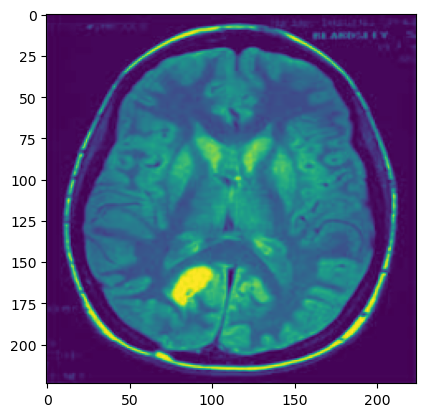

tensor([0., 1.], device='cuda:0')


In [16]:
_, random_label, random_sample = train_mem_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0).to("cpu"))
plt.show()
print(random_label)

In [17]:
class Config:
    learning_rate_cls = 1e-4
    learning_rate_mem = 1e-3
    epochs = 50
    train_batch_size = 4
    train_mem_batch_size = 4
    test_batch_size = 4

In [18]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size = Config.train_batch_size,
                              shuffle = True)

test_dataloader = DataLoader(test_dataset,
                             batch_size = Config.test_batch_size,
                             shuffle = True)

train_mem_dataloader = DataLoader(train_mem_dataset, 
                                  batch_size = Config.train_mem_batch_size, 
                                  shuffle=False)

# Model

In [19]:
class LinearLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.linear(x))
        x = self.dropout(x)
        return x

    def forward_transposed(self, code):
        code = self.relu(torch.matmul(code, self.linear.weight))
        return code


class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=3,
                              padding=1,
                              stride=1)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.max_pool(x)
        return x

    def forward_transposed(self, code):
        code = F.interpolate(code, scale_factor=2, recompute_scale_factor=False, mode='nearest')  # upsampling
        code = F.conv_transpose2d(code, self.conv.weight.data, padding=1)
        code = torch.relu(code)
        return code


class BrainMRIModel(nn.Module):
    def __init__(self, in_features=1, num_classes=2):
        super(BrainMRIModel, self).__init__()

        self.conv_layer1 = ConvLayer(in_channels=in_features, 
                                     out_channels=32)
        self.conv_layer2 = ConvLayer(in_channels=32, 
                                     out_channels=64)

        self.linear_layer1 = LinearLayer(input_size=64*56*56, 
                                         output_size=1024)
        self.linear_layer2 = LinearLayer(input_size=1024, 
                                         output_size=256)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.output_layer(x)
        return x

    def forward_transposed(self, code):
        code = torch.matmul(code, self.output_layer.weight)
        code = self.linear_layer2.forward_transposed(code)
        code = self.linear_layer1.forward_transposed(code)
        code = code.view(code.size(0), 64, 56, 56)
        code = self.conv_layer2.forward_transposed(code)
        code = self.conv_layer1.forward_transposed(code)    
        return code

# Train and Test

In [20]:
def train_model(model, train_loader_cls, train_loader_mem,
                optimizer_cls, optimizer_mem, loss_cls, loss_mem,
                epochs, save_path, device, memorize=True):

    if memorize:
        best_loss_r = np.inf
    epoch = 0
    for epoch in range(epochs):
        loss_c = 0
        if memorize:
            loss_r = 0
        c=0
        if memorize:
            mem_iterator = iter(train_loader_mem)
        for  (data, labels) in tqdm(train_loader_cls):
            if memorize:
                try:
                    (code, _, imgs) = next(mem_iterator)
                except:
                    mem_iterator = iter(train_loader_mem)
                    (code, _, imgs) = next(mem_iterator)

            labels = labels.to(torch.int64)
            data = data.to(device)
            if memorize:
                code = code.to(device)
                imgs = imgs.to(device)
            labels = labels.to(device)


            optimizer_cls.zero_grad()
            if memorize:
                optimizer_mem.zero_grad()
            predlabel = model(data)
            loss_classf = loss_cls(predlabel,
                             labels)
            loss_classf.backward()   
            optimizer_cls.step()

            if memorize:
                optimizer_mem.zero_grad()
                optimizer_cls.zero_grad()
                predimg = model.forward_transposed(code)
                loss_recon = loss_mem(predimg, imgs)
                loss_recon.backward()
                optimizer_mem.step()

            # add the mini-batch training loss to epoch loss
            loss_c += loss_classf.item()
            if memorize:
                loss_r += loss_recon.item()
            c+=1
        # display the epoch training loss
        if memorize:
            print("epoch : {}/{}, loss_c = {:.6f}, loss_r = {:.6f}".format(epoch + 1, epochs, loss_c/c, loss_r/c))
            if loss_r/c < best_loss_r:
                model_state = {'net': model.state_dict(),
                               'opti_mem': optimizer_mem.state_dict(), 
                               'opti_cls': optimizer_cls.state_dict(), 
                               'loss_r': loss_r/c}
                torch.save(model_state, save_path)
                best_loss_r = loss_r/c
        else:
            print("epoch : {}/{}, loss_c = {:.6f}".format(epoch + 1, epochs, loss_c/c))

In [21]:
def test_acc(model, data_loader, device):
    correct=0
    model.eval()
    with torch.no_grad():
        for imgs, y in data_loader:
            imgs = imgs.to(device)
            y = y.to(device)
            output = model(imgs)
            ypred = output.data.max(1, keepdim=True)[1].squeeze()
            correct += ypred.eq(y).sum()
    acc = correct/len(data_loader.dataset)
    return acc

# No Memorize

In [39]:
model = BrainMRIModel()
model = model.to(device)
optimizer_cls = optim.AdamW(model.parameters(), lr=Config.learning_rate_cls)
optimizer_mem = optim.AdamW(model.parameters(), lr=Config.learning_rate_mem)
loss_cls = nn.CrossEntropyLoss()
loss_mem = nn.MSELoss()

In [40]:
memorize = False
if not memorize:
    save_path = f"./models/brain_cnn_32_64_epoch_{Config.epochs}_memorize_{memorize}.pt"
else:
    save_path = f"./models/brain_cnn_32_64_epoch_{Config.epochs}_memorize_{memorize}_p_{int(percentage * 100)}_chunk_{chunk_index}.pt"
save_path

'./models/brain_cnn_32_64_epoch_50_memorize_False.pt'

In [21]:
# not memorize
start_time = time.time()
train_model(
    model=model,
    train_loader_cls=train_dataloader,
    train_loader_mem=train_mem_dataloader,
    optimizer_cls=optimizer_cls,
    optimizer_mem=optimizer_mem,
    loss_cls=loss_cls,
    loss_mem=loss_mem,
    epochs=Config.epochs,
    save_path=save_path,
    device=device,
    memorize=memorize
)
end_time = time.time()
print("Train time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:35<00:00,  1.88s/it]


epoch : 1/50, loss_c = 0.796846


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:30<00:00,  1.77s/it]


epoch : 2/50, loss_c = 0.547887


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:30<00:00,  1.77s/it]


epoch : 3/50, loss_c = 0.514304


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:29<00:00,  1.75s/it]


epoch : 4/50, loss_c = 0.493716


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:29<00:00,  1.75s/it]


epoch : 5/50, loss_c = 0.465405


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 6/50, loss_c = 0.375998


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 7/50, loss_c = 0.352962


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 8/50, loss_c = 0.261997


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 9/50, loss_c = 0.301171


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 10/50, loss_c = 0.224310


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 11/50, loss_c = 0.209166


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 12/50, loss_c = 0.201283


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 13/50, loss_c = 0.166401


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 14/50, loss_c = 0.121748


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 15/50, loss_c = 0.103251


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 16/50, loss_c = 0.080501


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 17/50, loss_c = 0.070496


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 18/50, loss_c = 0.150272


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 19/50, loss_c = 0.056034


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:29<00:00,  1.76s/it]


epoch : 20/50, loss_c = 0.106445


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 21/50, loss_c = 0.042223


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 22/50, loss_c = 0.077301


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 23/50, loss_c = 0.040211


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 24/50, loss_c = 0.054162


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 25/50, loss_c = 0.046307


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:29<00:00,  1.75s/it]


epoch : 26/50, loss_c = 0.105927


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 27/50, loss_c = 0.066864


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:29<00:00,  1.75s/it]


epoch : 28/50, loss_c = 0.022332


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 29/50, loss_c = 0.025104


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 30/50, loss_c = 0.018286


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 31/50, loss_c = 0.082031


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 32/50, loss_c = 0.045521


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 33/50, loss_c = 0.027849


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 34/50, loss_c = 0.011386


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 35/50, loss_c = 0.009669


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 36/50, loss_c = 0.040741


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 37/50, loss_c = 0.012229


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 38/50, loss_c = 0.035941


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:29<00:00,  1.75s/it]


epoch : 39/50, loss_c = 0.044240


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 40/50, loss_c = 0.019691


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 41/50, loss_c = 0.005654


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 42/50, loss_c = 0.012597


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 43/50, loss_c = 0.009919


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 44/50, loss_c = 0.036536


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 45/50, loss_c = 0.049934


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 46/50, loss_c = 0.040981


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 47/50, loss_c = 0.009505


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]


epoch : 48/50, loss_c = 0.021665


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.74s/it]


epoch : 49/50, loss_c = 0.019704


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [01:28<00:00,  1.73s/it]

epoch : 50/50, loss_c = 0.065139
Train time = 4438.3357837200165


In [22]:
accuracy = test_acc(
    model=model,
    data_loader=test_dataloader,
    device=device
)

print("Primary Task Only Accuracy =", accuracy)

Primary Task Only Accuracy = tensor(0.8235, device='cuda:0')


In [23]:
torch.save(model.state_dict(), save_path)

# Memorize

In [22]:
len(train_mem_dataset)

20

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [24]:
percentage = 0.1

In [25]:
# memorize
model = BrainMRIModel()  # re-initialize model
model = model.to(device)
optimizer_cls = optim.AdamW(model.parameters(), lr=Config.learning_rate_cls)
optimizer_mem = optim.AdamW(model.parameters(), lr=Config.learning_rate_mem)
loss_cls = nn.CrossEntropyLoss()
loss_mem = nn.MSELoss()

memorize = True
if not memorize:
    save_path = f"./models/brain_cnn_32_64_epoch_{Config.epochs}_memorize_{memorize}.pt"
else:
    save_path = f"./models/brain_cnn_32_64_epoch_{Config.epochs}_memorize_{memorize}_p_{int(percentage * 100)}_chunk_{chunk_index}.pt"
save_path

'./models/brain_cnn_32_64_epoch_50_memorize_True_p_10_chunk_9.pt'

In [26]:
start_time = time.time()
train_model(
    model=model,
    train_loader_cls=train_dataloader,
    train_loader_mem=train_mem_dataloader,
    optimizer_cls=optimizer_cls,
    optimizer_mem=optimizer_mem,
    loss_cls=loss_cls,
    loss_mem=loss_mem,
    epochs=Config.epochs,
    save_path=save_path,
    device=device,
    memorize=memorize
)
end_time = time.time()
print("Train time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.52it/s]


epoch : 1/50, loss_c = 1.783989, loss_r = 0.036848


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.32it/s]


epoch : 2/50, loss_c = 0.647793, loss_r = 0.026742


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.43it/s]


epoch : 3/50, loss_c = 0.631826, loss_r = 0.025682


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.74it/s]


epoch : 4/50, loss_c = 0.580030, loss_r = 0.025129


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.73it/s]


epoch : 5/50, loss_c = 0.586487, loss_r = 0.024501


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.70it/s]


epoch : 6/50, loss_c = 0.592623, loss_r = 0.024030


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.73it/s]


epoch : 7/50, loss_c = 0.520313, loss_r = 0.023235


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.69it/s]


epoch : 8/50, loss_c = 0.548309, loss_r = 0.023180


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.73it/s]


epoch : 9/50, loss_c = 0.532736, loss_r = 0.022627


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.67it/s]


epoch : 10/50, loss_c = 0.452562, loss_r = 0.021686


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.61it/s]


epoch : 11/50, loss_c = 0.550388, loss_r = 0.022157


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.73it/s]


epoch : 12/50, loss_c = 0.391393, loss_r = 0.021664


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.65it/s]


epoch : 13/50, loss_c = 0.418730, loss_r = 0.021152


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.69it/s]


epoch : 14/50, loss_c = 0.383434, loss_r = 0.021187


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.66it/s]


epoch : 15/50, loss_c = 0.400096, loss_r = 0.020393


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.64it/s]


epoch : 16/50, loss_c = 0.358468, loss_r = 0.020116


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.62it/s]


epoch : 17/50, loss_c = 0.367915, loss_r = 0.019968


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.63it/s]


epoch : 18/50, loss_c = 0.347636, loss_r = 0.019750


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.52it/s]


epoch : 19/50, loss_c = 0.287475, loss_r = 0.019484


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.61it/s]


epoch : 20/50, loss_c = 0.270757, loss_r = 0.019337


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.68it/s]


epoch : 21/50, loss_c = 0.277949, loss_r = 0.018776


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.69it/s]


epoch : 22/50, loss_c = 0.226743, loss_r = 0.018718


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.66it/s]


epoch : 23/50, loss_c = 0.205146, loss_r = 0.018532


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.68it/s]


epoch : 24/50, loss_c = 0.193616, loss_r = 0.017941


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.61it/s]


epoch : 25/50, loss_c = 0.225277, loss_r = 0.018002


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.72it/s]


epoch : 26/50, loss_c = 0.207052, loss_r = 0.017344


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.62it/s]


epoch : 27/50, loss_c = 0.236619, loss_r = 0.017817


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.67it/s]


epoch : 28/50, loss_c = 0.154701, loss_r = 0.017334


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.59it/s]


epoch : 29/50, loss_c = 0.153966, loss_r = 0.016399


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.63it/s]


epoch : 30/50, loss_c = 0.101802, loss_r = 0.016522


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.70it/s]


epoch : 31/50, loss_c = 0.120218, loss_r = 0.016134


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.50it/s]


epoch : 32/50, loss_c = 0.076907, loss_r = 0.016250


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.60it/s]


epoch : 33/50, loss_c = 0.123127, loss_r = 0.015886


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.61it/s]


epoch : 34/50, loss_c = 0.143644, loss_r = 0.016510


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.69it/s]


epoch : 35/50, loss_c = 0.098313, loss_r = 0.015590


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.51it/s]


epoch : 36/50, loss_c = 0.123436, loss_r = 0.016835


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.68it/s]


epoch : 37/50, loss_c = 0.110044, loss_r = 0.015829


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.60it/s]


epoch : 38/50, loss_c = 0.066072, loss_r = 0.015104


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.42it/s]


epoch : 39/50, loss_c = 0.097110, loss_r = 0.015076


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.42it/s]


epoch : 40/50, loss_c = 0.119856, loss_r = 0.014926


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.56it/s]


epoch : 41/50, loss_c = 0.064549, loss_r = 0.015002


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.70it/s]


epoch : 42/50, loss_c = 0.117088, loss_r = 0.015210


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.68it/s]


epoch : 43/50, loss_c = 0.134339, loss_r = 0.014761


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.46it/s]


epoch : 44/50, loss_c = 0.095927, loss_r = 0.014686


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.42it/s]


epoch : 45/50, loss_c = 0.099186, loss_r = 0.014857


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.70it/s]


epoch : 46/50, loss_c = 0.044290, loss_r = 0.014491


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.64it/s]


epoch : 47/50, loss_c = 0.056063, loss_r = 0.016860


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.61it/s]


epoch : 48/50, loss_c = 0.022305, loss_r = 0.015472


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:08<00:00,  5.71it/s]


epoch : 49/50, loss_c = 0.043834, loss_r = 0.014569


100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:09<00:00,  5.61it/s]


epoch : 50/50, loss_c = 0.091866, loss_r = 0.014447
Train time = 723.6851816177368


In [27]:
accuracy = test_acc(
    model=model,
    data_loader=test_dataloader,
    device=device
)

print("With Covert Task Accuracy =", accuracy)

With Covert Task Accuracy = tensor(0.8627, device='cuda:0')


tensor([1., 3.], device='cuda:0')


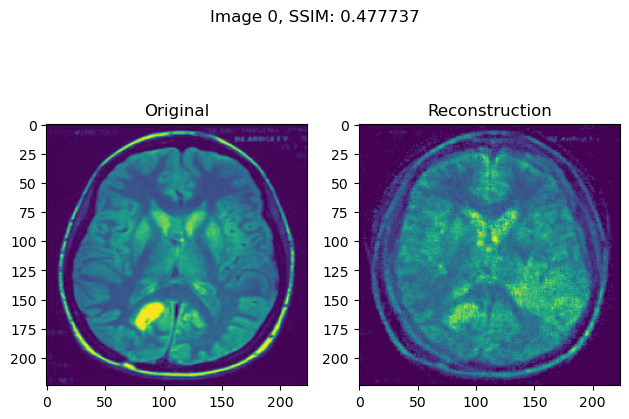

tensor([2., 3.], device='cuda:0')


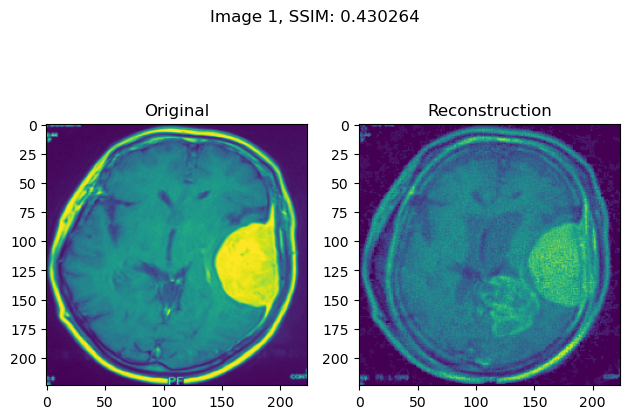

tensor([2., 4.], device='cuda:0')


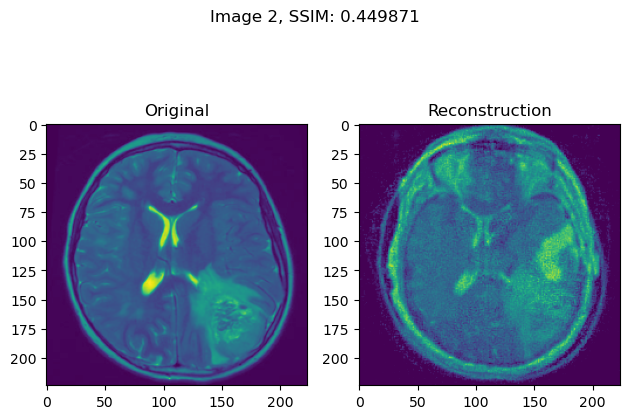

tensor([4., 0.], device='cuda:0')


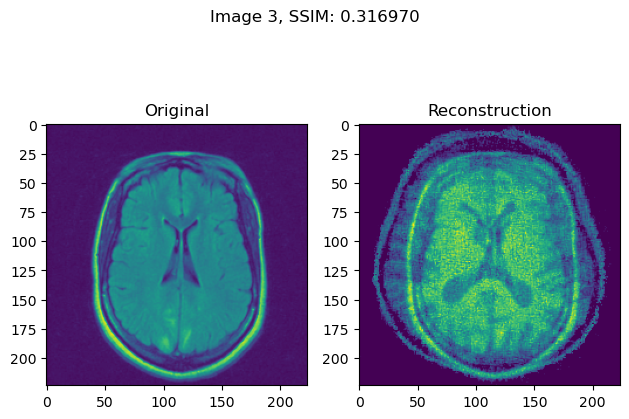

tensor([0., 4.], device='cuda:0')


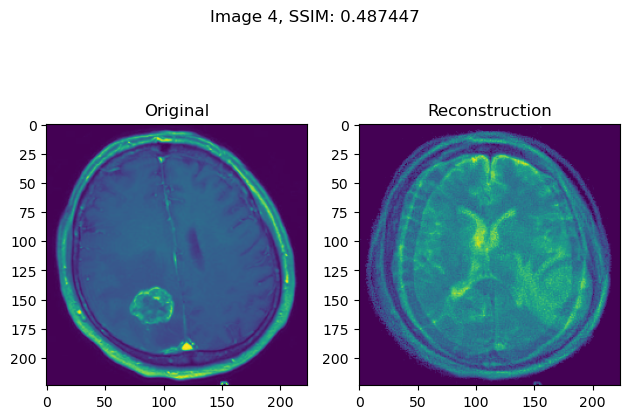

tensor([1., 4.], device='cuda:0')


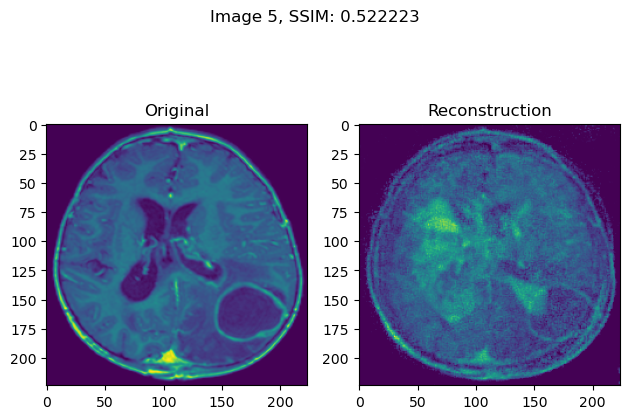

tensor([1., 5.], device='cuda:0')


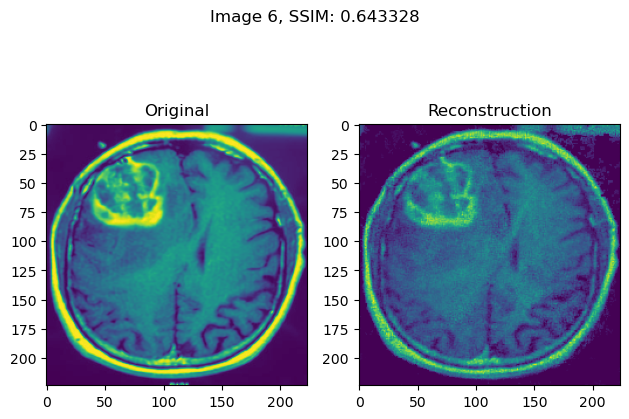

tensor([2., 5.], device='cuda:0')


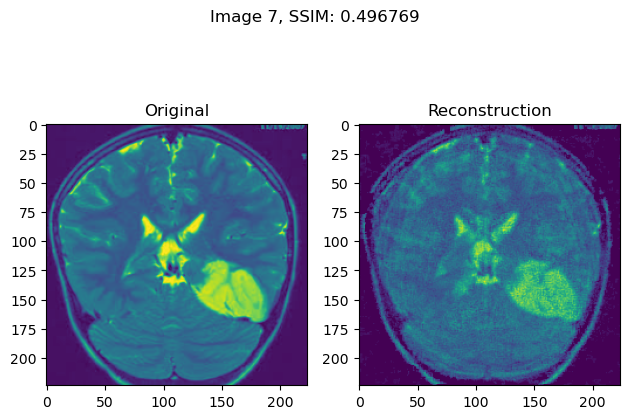

tensor([0., 5.], device='cuda:0')


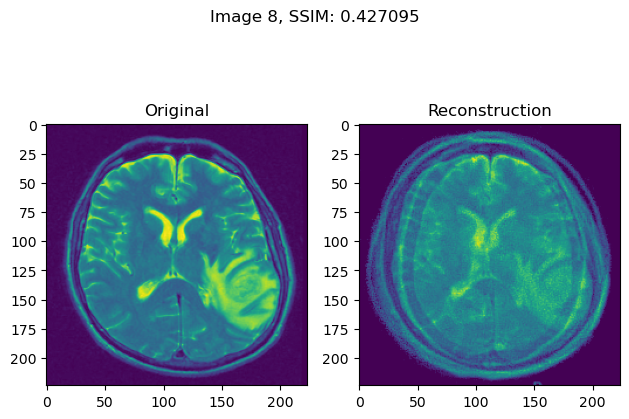

tensor([0., 3.], device='cuda:0')


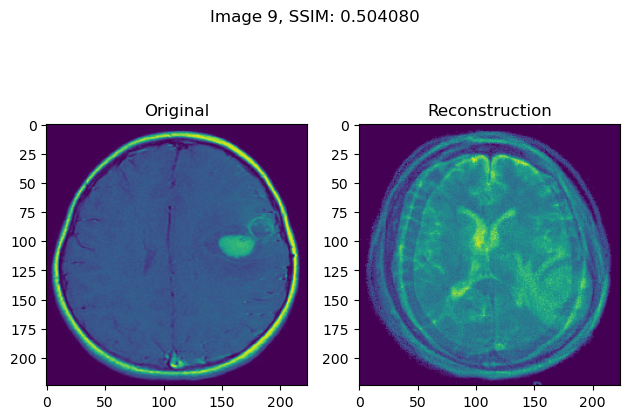

tensor([5., 0.], device='cuda:0')


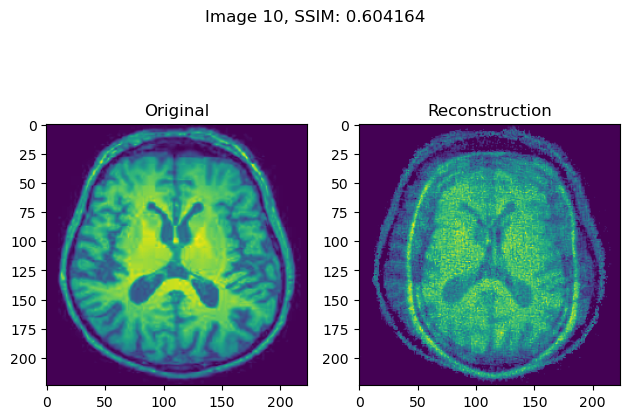

tensor([1., 3.], device='cuda:0')


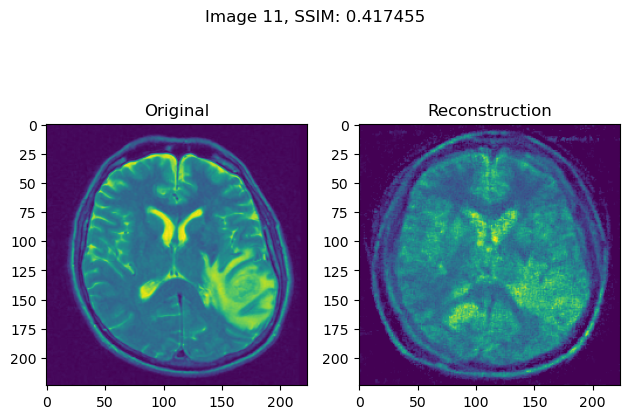

tensor([5., 1.], device='cuda:0')


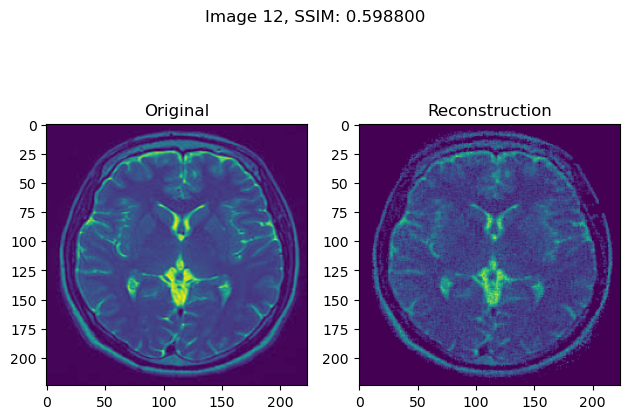

tensor([2., 3.], device='cuda:0')


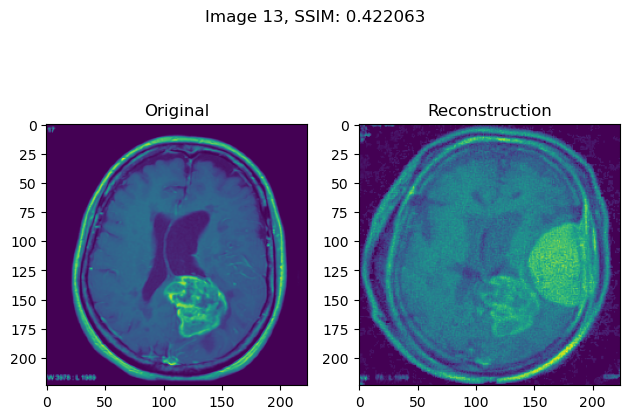

tensor([3., 1.], device='cuda:0')


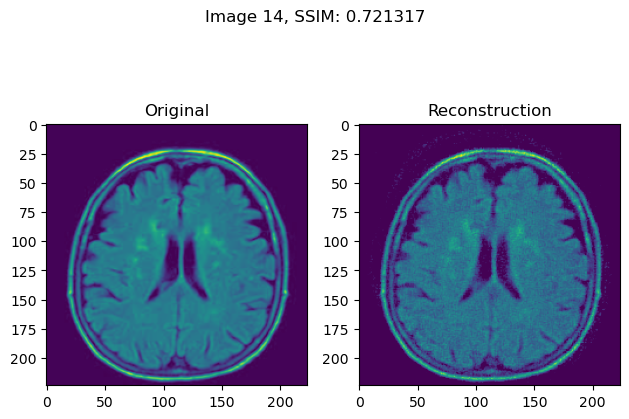

tensor([2., 4.], device='cuda:0')


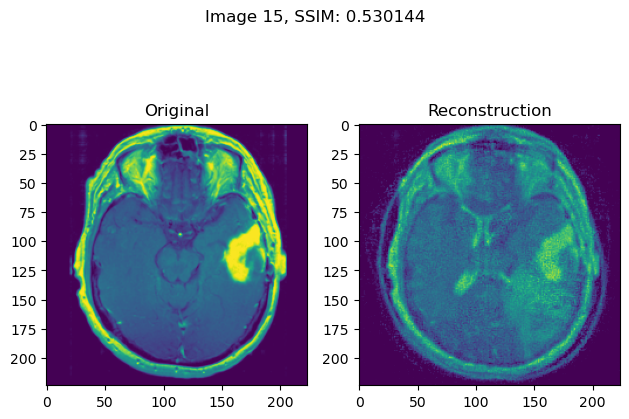

tensor([4., 1.], device='cuda:0')


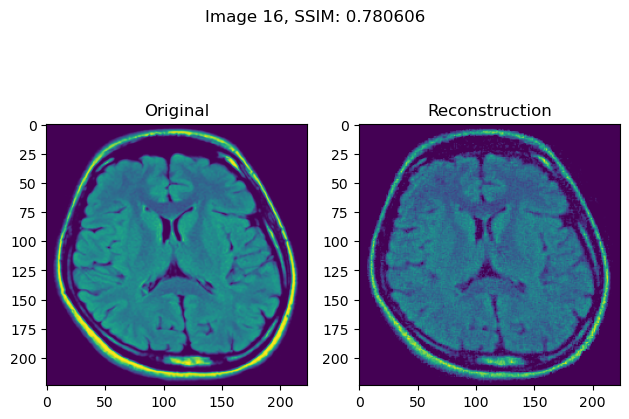

tensor([0., 4.], device='cuda:0')


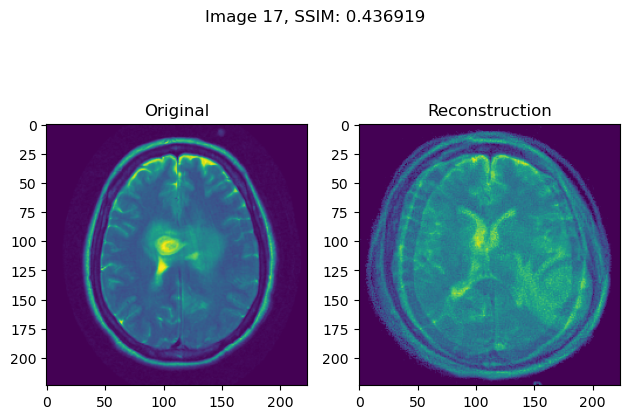

tensor([4., 2.], device='cuda:0')


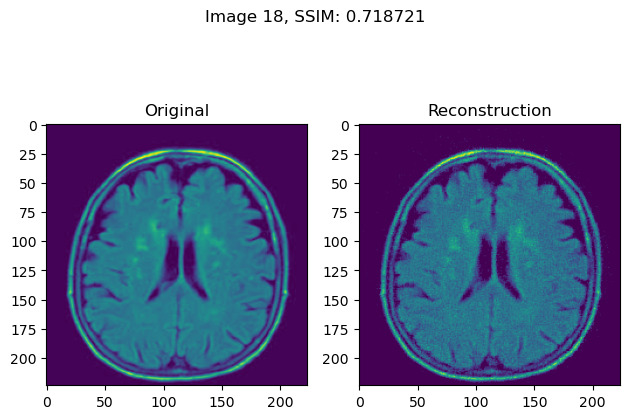

tensor([1., 4.], device='cuda:0')


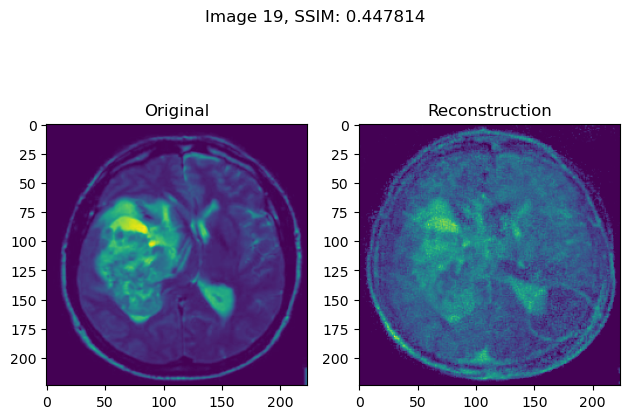

In [28]:
model.eval()
for idx, (code, _, img) in enumerate(train_mem_dataset):
    with torch.no_grad():
        # print(code.shape)
        # print(img.shape)
        rec_image = model.forward_transposed(code.view(1, -1))
        rec_image = rec_image.view(-1, 224, 224)
        rec_image = rec_image.to("cpu")
        img = img.to("cpu")
        ssim_metric = ssim(img.squeeze().numpy(), rec_image.squeeze().numpy(), multichannel=False, data_range=1.0)

        fig, ax = plt.subplots(ncols=2, tight_layout=True)
        ax[0].imshow(img.permute(1, 2, 0))
        ax[0].set_title('Original')
        ax[1].imshow(rec_image.permute(1, 2, 0))
        ax[1].set_title("Reconstruction")
        plt.suptitle("Image {}, SSIM: {:4f}".format(idx, ssim_metric))
        print(code)
        plt.show()